In [66]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import requests
from lxml import html

import scipy.interpolate as interp

plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (7,6)

plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (10,8)

# Define some constants

In [44]:
# Mostly masses of the relevant isotopes, taken from Wikipedia

M_xe136 = 135.907219 # AMU
M_cs136 = 135.9073116 # AMU
M_cs135 = 134.9059770 # AMU
M_ta181 = 180.9479958 # AMU
M_w181 = 180.948197 # AMU
M_w180 = 179.946704 # AMU
M_n = 1.008665 # AMU 
M_p = 1.00727647 # AMU
M_e = 0.00054858 # AMU

MeV_per_AMU = 931.49432


In [45]:
Qvalues = dict()

Qvalues['pn_xe136'] = MeV_per_AMU * ( (M_cs136 - M_e*55 + M_n) - (M_xe136 - M_e*54 + M_p) )
Qvalues['p2n_xe136'] = MeV_per_AMU * ( (M_cs135 - M_e*55 + 2*M_n) - (M_xe136 - M_e*54 + M_p) )
Qvalues['pn_ta181'] = MeV_per_AMU * ( (M_w181 - M_e*74 + M_n) - (M_ta181 - M_e*73 + M_p) )
Qvalues['p2n_ta181'] = MeV_per_AMU * ( (M_w180 - M_e*74 + 2*M_n) - (M_ta181 - M_e*73 + M_p) )


print('Q-values for various reactions:')
for reaction, Q in Qvalues.items():
    print('\t{}:\t{:4.4} MeV'.format(reaction,Q))
    
    
    

Q-values for various reactions:
	pn_xe136:	0.8687 MeV
	p2n_xe136:	7.697 MeV
	pn_ta181:	0.9698 MeV
	p2n_ta181:	7.651 MeV


# Energy resolution from scattered neutrons

There are a few components to the energy resolution:
* Energy smearing due to straggling in the entrance/exit foils
* Energy loss in the target itself
* Timing resolution of time-of-flight (TOF) setup

## 1. Straggling in entrance/exit foils

Did two TRIM simulations of protons impinging on a 0.1mil-thick Tantalum foil. 

In [46]:
# Not yet finished

## 2. Energy loss in the target

In [47]:
spower = pd.read_csv('target_energy_loss/ProtonsStoppingInXenon_TRIM.txt',\
                              skiprows=22,\
                              skipfooter=13,\
                              delimiter='\s+')
mask = spower['unit'] != 'MeV'
spower['Energy'].loc[mask] = spower['Energy'].loc[mask]/1000.


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


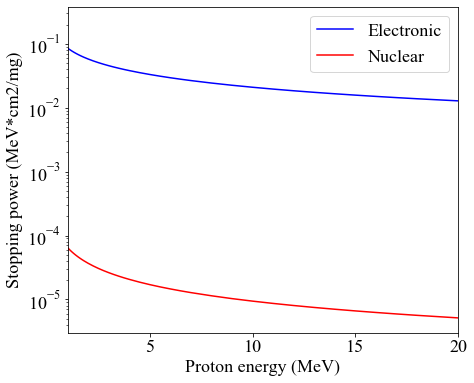

In [48]:
# Plot the stopping power from TRIM

plt.plot(spower['Energy'],spower['Elec.'],'-b',label='Electronic')
plt.plot(spower['Energy'],spower['Nuclear'],'-r',label='Nuclear')
#plt.plot(stopping_power[:,0],stopping_power[:,2],'-r',label='Nuclear')

#plt.xscale('log')
plt.xlabel('Proton energy (MeV)')
plt.yscale('log')
plt.ylabel('Stopping power (MeV*cm2/mg)')
plt.xlim(1.,20.)
plt.legend()




In [49]:
# Interpolate the stopping power into a function
from scipy.interpolate import interp1d

StoppingPower = interp1d(spower['Energy'],spower['Elec.']*1000.) # Factor of 1000 gives me 
                                                                 # units of MeV*cm2/g

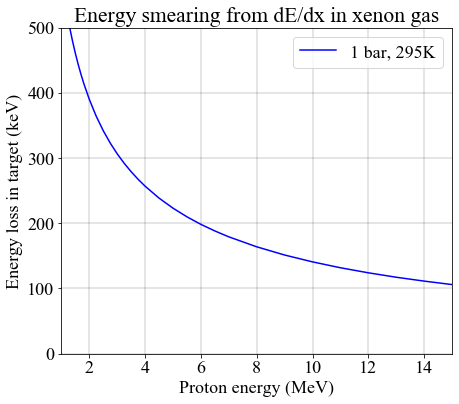

In [50]:
# Calculate the actual energy loss using the stopping power and different density assumptions.

xe_gas_density = 0.0053 # g/cm3, from NIST Webbook at 295K and 1 bar
target_diameter = 0.5 * 2.54 # 1/2" diameter target length, in cm

energy_loss = StoppingPower(spower['Energy']) * xe_gas_density * target_diameter

mask = spower['Energy'] > 1.

# Note: multiply by 1000 to get units of keV on y-axis
plt.plot(spower['Energy'].loc[mask],energy_loss[mask]*1000,'-b',label='1 bar, 295K')
#plt.plot(spower['Energy'].loc[mask],energy_loss[mask]*1000/2.,'-g',label='0.5 bar, 295K')
plt.xlim(1.,15.)
plt.title("Energy smearing from dE/dx in xenon gas")
plt.xlabel('Proton energy (MeV)')
plt.ylabel('Energy loss in target (keV)')
plt.ylim(0.,500.)
plt.legend()
plt.grid(linewidth=0.2,color=(0.,0.,0.,0.2))
plt.savefig('plots/energy_loss_in_xe_cell_vs_proton_energy.png',\
            dpi=200,\
            bbox_inches='tight')




The conclusion here is that the proton energy loss will produce O(100)keV uncertainty in the energy of the incoming proton, which will smear out our overall energy resolution. We can model this as a uniform distribution, as the cross section doesn't change too much for differences of O(100) keV.

We can get somewhat better resolution by changing the density of the gas in the target, however this will decrease our signal/background ratio. 

## 3. TOF resolution

In [51]:
def TOF_vs_energy( energy ):
    # Energy must be given in units of MeV
    distance = 13. # m
    c = 3e8 # m/s
    m_N = 939.56563 # MeV
    
    TOF = distance / ( c*np.sqrt( 1 - ( 1 / (energy/m_N + 1) )**2  ) )
    
    return TOF

def Energy_vs_TOF( TOF ):
    # TOF must be given in units of seconds
    distance = 13. # m
    c = 3e8 # m/s
    m_N = 939.56563 # MeV
    
    energy = m_N * ( 1 / np.sqrt(1-(distance/TOF/c)**2) - 1 )
    
    return energy

def TOF_vs_distance( distance, energy ):
    # Energy must be given in units of MeV
    distance = distance # m
    c = 3e8 # m/s
    m_N = 939.56563 # MeV
    
    TOF = distance / ( c*np.sqrt( 1 - ( 1 / (energy/m_N + 1) )**2  ) )
    
    return TOF

def GammaTOF_vs_distance( distance ):
    c = 3e8 # m/s
    
    return distance / c

In [52]:
1/(TOF_vs_distance(1., 7.)*1.e9)

print('Gamma TOF: {:4.4}'.format(GammaTOF_vs_distance(13.)*1.e9))

Gamma TOF: 43.33


TOF at 5 MeV: 421.7 ns
TOF at 6 MeV: 385.3 ns
TOF at 10 MeV: 299.4 ns
Energy uncertainty at 10 MeV, given 2ns timing uncertainty: 133.5 keV
Energy uncertainty at 5 MeV, given 2ns timing uncertainty: 47.37 keV


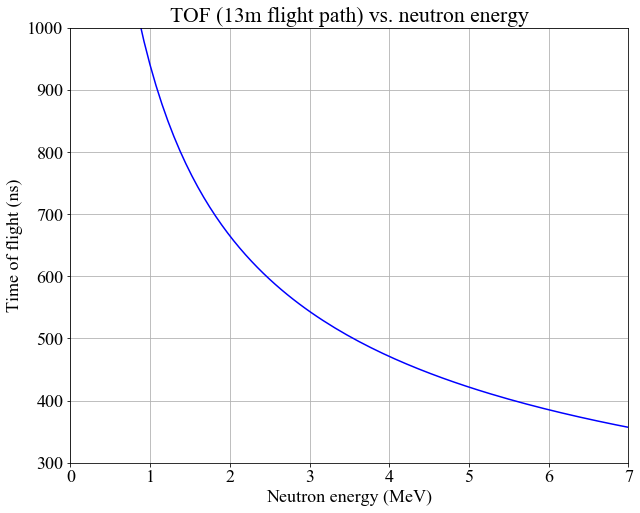

In [69]:
energy = np.linspace(0.1,15.,200)

plt.plot(energy,TOF_vs_energy(energy)*1e9,'-b')

plt.xlabel('Neutron energy (MeV)')
plt.ylabel('Time of flight (ns)')
plt.ylim(300.,1000.)
plt.xlim(0.,7.0)
plt.title('TOF (13m flight path) vs. neutron energy')

print('TOF at 5 MeV: {:4.4} ns'.format(TOF_vs_energy(5.)*1e9))
print('TOF at 6 MeV: {:4.4} ns'.format(TOF_vs_energy(6.)*1e9))
print('TOF at 10 MeV: {:4.4} ns'.format(TOF_vs_energy(10.)*1e9))

print('Energy uncertainty at 10 MeV, given 2ns timing uncertainty: {:4.4} keV'.format(\
                                np.abs(Energy_vs_TOF(302e-9)-Energy_vs_TOF(300e-9))*1000))
print('Energy uncertainty at 5 MeV, given 2ns timing uncertainty: {:4.4} keV'.format(\
                                np.abs(Energy_vs_TOF(424e-9)-Energy_vs_TOF(422e-9))*1000))
plt.grid()


TOF for 590 keV: 404.1


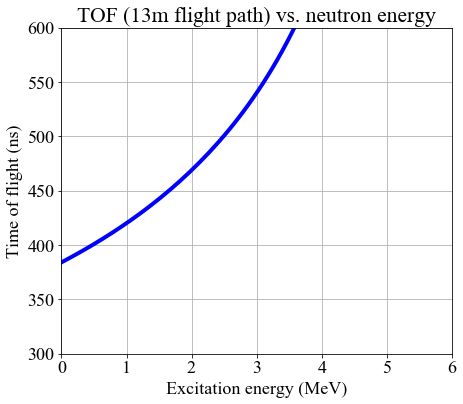

In [54]:
energy = np.linspace(0.1,15.,200)
state_energy = 7. - energy - .873 - 0.0875
plt.plot(state_energy,TOF_vs_energy(energy)*1e9,'-b',linewidth=4)


plt.xlabel('Excitation energy (MeV)')
plt.ylabel('Time of flight (ns)')
plt.ylim(300.,600.)
plt.xlim(0,6.)
plt.title('TOF (13m flight path) vs. neutron energy')
plt.grid()

energy = (0.59 + 0.873 + 0.0875 - 7.)*-1.
TOF_vs_energy(energy)

print('TOF for 590 keV: {:4.4}'.format(TOF_vs_energy(energy)*1.e9))

# print('TOF at 5 MeV: {:4.4} ns'.format(TOF_vs_energy(5.)*1e9))
# print('TOF at 10 MeV: {:4.4} ns'.format(TOF_vs_energy(10.)*1e9))

# print('Energy uncertainty at 10 MeV, given 2ns timing uncertainty: {:4.4} keV'.format(\
#                                 np.abs(Energy_vs_TOF(302e-9)-Energy_vs_TOF(300e-9))*1000))
# print('Energy uncertainty at 5 MeV, given 2ns timing uncertainty: {:4.4} keV'.format(\
#                                 np.abs(Energy_vs_TOF(424e-9)-Energy_vs_TOF(422e-9))*1000))

Energy at 466 ns: 4.089 MeV
Energy at 488 ns: 3.726 MeV
Energy at 415 ns: 5.164 MeV


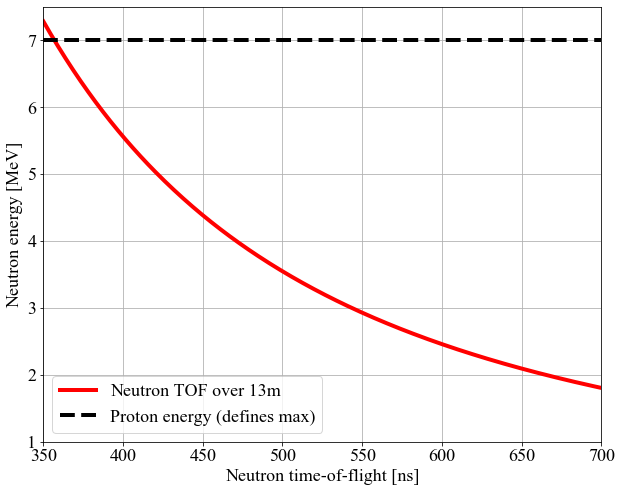

In [76]:
x_TOF = np.linspace(350.,700.,300)
y_energy = Energy_vs_TOF(x_TOF*1e-9)

plt.plot(x_TOF,y_energy,'-r',linewidth=4,label='Neutron TOF over 13m')
plt.grid()
plt.xlabel('Neutron time-of-flight [ns]')
plt.ylabel('Neutron energy [MeV]')

max_energy = np.ones(300)*7.

plt.plot(x_TOF,max_energy,'--k',linewidth=4,label='Proton energy (defines max)')
plt.legend()
plt.xlim(350.,700.)
plt.ylim(1.,7.5)

thresholds_dict[]

print('Energy at 466 ns: {:4.4} MeV'.format(Energy_vs_TOF(466.*1e-9)))
print('\t ')
print('Energy at 488 ns: {:4.4} MeV'.format(Energy_vs_TOF(488.*1e-9)))
print('Energy at 415 ns: {:4.4} MeV'.format(Energy_vs_TOF(415.*1e-9)))






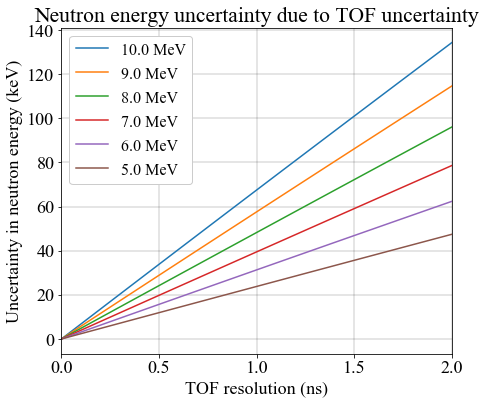

In [56]:

uncertainty_6MeV = np.zeros(100)
uncertainty_7MeV = np.zeros(100)
uncertainty_8MeV = np.zeros(100)
uncertainty_9MeV = np.zeros(100)
uncertainty_10MeV = np.zeros(100)
uncertainty = np.zeros((6,100))
res = np.linspace(0.,2.,100)

for j in range(6):
    for i in range(100):
        
        energy = float(10.-j)
    
        uncertainty[j][i] = np.abs( Energy_vs_TOF( TOF_vs_energy(energy) + res[i]*1.e-9 ) - \
                              Energy_vs_TOF( TOF_vs_energy(energy) ) )*1000
        
    plt.plot(res,uncertainty[j],label='{} MeV'.format(10.-j))

plt.title('Neutron energy uncertainty due to TOF uncertainty')
plt.xlabel('TOF resolution (ns)')
plt.ylabel('Uncertainty in neutron energy (keV)')
plt.legend(fontsize=16,framealpha=1)
plt.xlim(0.,2.)
plt.grid(linewidth=0.2,color=(0.,0.,0.,0.2))
plt.savefig('plots/neutron_energy_resolution_vs_TOF_resolution.png',\
            dpi=200,\
            bbox_inches='tight')






In [57]:
def TOFEnergyUncertainty1Sigma( neutron_energy, TOFresolution ):
    
    output = np.zeros((len(neutron_energy),len(TOFresolution)))
    
    for i in range(len(neutron_energy)):
        for j in range(len(TOFresolution)):
            output[i,j] = np.abs( \
                            Energy_vs_TOF( TOF_vs_energy(neutron_energy[i]) + TOFresolution[j]*1.e-9 ) - \
                            Energy_vs_TOF( TOF_vs_energy(neutron_energy[i]) ) \
                                )*1000

    return output



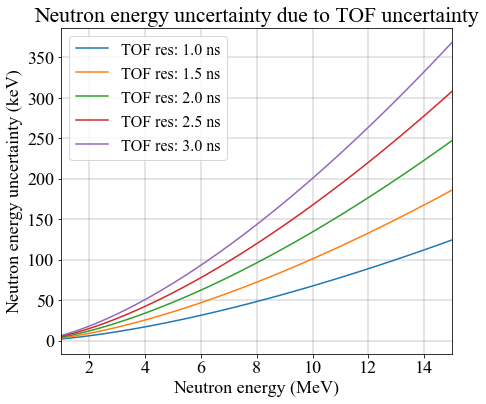

In [58]:
energy = np.linspace(1.,15.,100) # MeV
tof_res = np.linspace(1.,3.,5) # ns

uncertainty_matrix = TOFEnergyUncertainty1Sigma(energy,tof_res)

for i in range(len(uncertainty_matrix[0,:])):
    plt.plot(energy,uncertainty_matrix[:,i],label='TOF res: {} ns'.format(tof_res[i]))
    
    
plt.xlabel('Neutron energy (MeV)')
plt.ylabel('Neutron energy uncertainty (keV)')
plt.legend(fontsize=16)
plt.xlim(1.,15.)
plt.title("Neutron energy uncertainty due to TOF uncertainty")
plt.grid(linewidth=0.2,color=(0.,0.,0.,0.2))
plt.savefig('plots/neutron_energy_resolution_vs_neutron_energy.png',\
           dpi=200,\
           bbox_inches='tight')






## Putting it all together

We can now estimate the energy resolution given an incoming proton energy and an outgoing neutron. 

For now, we'll just assume the neutron loses 1 MeV to the reaction less energy than the incoming proton. 

In [59]:
def GaussianConvolvedWithUniform( x, u_width, x_offset, gauss_sigma ):
    
    # Gaussian convolved with a uniform distribution, assuming gaussian
    # mean is centered at 0
    xvals = np.linspace(x_offset-u_width/2.,x_offset+u_width/2.,500)
    dx = xvals[1]-xvals[0]
    
    if isinstance(x,float) or isinstance(x,int):
    
        p = 1/( (u_width)*np.sqrt(2*np.pi*gauss_sigma**2)  ) * \
            np.sum( np.exp(-(xvals-x)**2/(2*gauss_sigma**2)) )*dx
    else:
        p = np.zeros(len(x))
        for i in range(len(x)):
            p[i] = 1/( (u_width)*np.sqrt(2*np.pi*gauss_sigma**2)  ) * \
                np.sum( np.exp(-(xvals-x[i])**2/(2*gauss_sigma**2)) )*dx
            
    return p
    
    
    

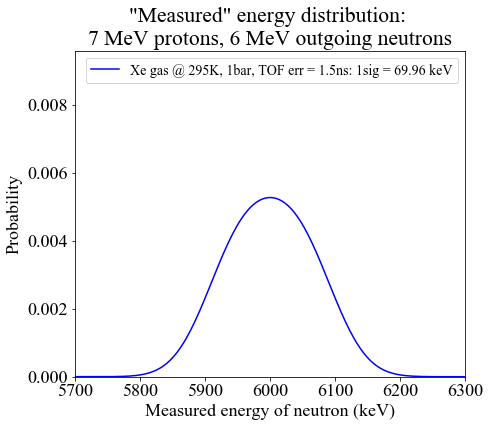

In [60]:
# Let's assume we have 1.5ns timing uncertainty, 8 MeV proton energy, and the outgoing neutron 
# energy is 6 MeV.
xe_gas_density = 0.0053 # g/cm3, from NIST Webbook at 295K and 1 bar
target_diameter = 0.5 * 2.54 # 1/2" diameter target length, in cm
proton_energy = 7. # MeV
neutron_energy = 6. # MeV
tof_error = 1.5 # ns


tof_Eres = TOFEnergyUncertainty1Sigma( np.array([neutron_energy]),\
                                      np.array([tof_error]) \
                                     )[0][0]
energy_loss = StoppingPower(proton_energy)*1000. * xe_gas_density * target_diameter



# Calculate the probability distribution as a function of energy:
smeared_energy = np.linspace(-500.+neutron_energy*1000,500.+neutron_energy*1000,300)
dE = smeared_energy[1]-smeared_energy[0]

standard_resolution = GaussianConvolvedWithUniform(smeared_energy,\
                                                   energy_loss,\
                                                   neutron_energy*1000.,\
                                                   tof_Eres)
reduced_pressure = GaussianConvolvedWithUniform(smeared_energy,\
                                                energy_loss/2.,\
                                                neutron_energy*1000.,\
                                                tof_Eres)
standard_resolution_variance = 0.
reduced_pressure_variance = 0.

for i in range(len(smeared_energy)):
    standard_resolution_variance += dE * (smeared_energy[i] - neutron_energy*1000)**2 \
                                        * standard_resolution[i]
    reduced_pressure_variance += dE * (smeared_energy[i]-neutron_energy*1000)**2 \
                                        * reduced_pressure[i]


plt.plot(smeared_energy,standard_resolution,'-b',\
         label='Xe gas @ 295K, 1bar, TOF err = 1.5ns: 1sig = {:4.4} keV'.format(np.sqrt(standard_resolution_variance)))
# plt.plot(smeared_energy,reduced_pressure,'-r',\
#          label='Xe gas @ 295K, 0.5bar, TOF err = 1.5ns: 1sig = {:4.4} keV'.format(np.sqrt(reduced_pressure_variance)))
plt.xlabel('Measured energy of neutron (keV)')
plt.ylabel('Probability')
plt.title('\"Measured\" energy distribution: \n7 MeV protons, 6 MeV outgoing neutrons')
plt.legend(loc='upper right',fontsize=14)
plt.ylim(0.,np.max(reduced_pressure)*1.3)
plt.xlim(neutron_energy*1000-300.,neutron_energy*1000+300.)

plt.savefig('plots/neutron_energy_distribution_6MeV_1p5ns_TOF.png',\
            dpi=200,\
            bbox_inches='tight')




# Signal/background estimate

We can compare cross sections and target densities to get approximate signal/background event rates. All cross sections used here come from the TENDL proton sub-libraries: https://tendl.web.psi.ch/tendl_2019/tendl2019.html

In [61]:
xe136_pn_xsec = np.genfromtxt('xsec_data/Xe136_pn_xsec.txt',skip_header=5)
xe136_p2n_xsec = np.genfromtxt('xsec_data/Xe136_p2n_xsec.txt',skip_header=5)
xe136_pnx_xsec = np.genfromtxt('xsec_data/Xe136_pnx_xsec.txt',skip_header=5)

ta181_pn_xsec = np.genfromtxt('xsec_data/Ta181_pn_xsec.txt',skip_header=5)
ta181_p2n_xsec = np.genfromtxt('xsec_data/Ta181_p2n_xsec.txt',skip_header=5)
ta181_pnx_xsec = np.genfromtxt('xsec_data/Ta181_pnx_xsec.txt',skip_header=5)

pb208_pnx_xsec = np.genfromtxt('xsec_data/Pb208_pnx_xsec.txt',skip_header=5)
pb207_pnx_xsec = np.genfromtxt('xsec_data/Pb207_pnx_xsec.txt',skip_header=5)
pb206_pnx_xsec = np.genfromtxt('xsec_data/Pb206_pnx_xsec.txt',skip_header=5)





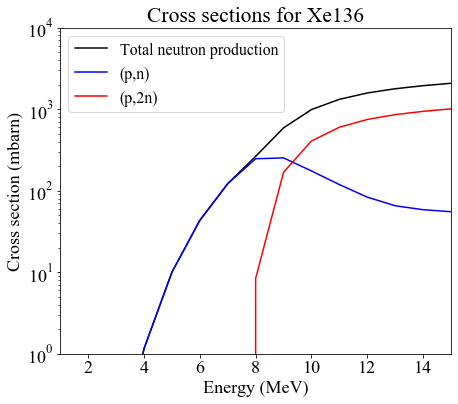

In [62]:
plt.plot(xe136_pnx_xsec[:,0],xe136_pnx_xsec[:,1],'-k',label='Total neutron production')
plt.plot(xe136_pn_xsec[:,0],xe136_pn_xsec[:,1],'-b',label='(p,n)')
plt.plot(xe136_p2n_xsec[:,0],xe136_p2n_xsec[:,1],'-r',label='(p,2n)')
#plt.plot(xe136_pn_xsec[:,0],xe136_pn_xsec[:,1]+xe136_p2n_xsec[:,1],'-m',label='(p,n)+(p,2n)')

plt.xlabel('Energy (MeV)')
plt.ylabel('Cross section (mbarn)')
#plt.xscale('log')
plt.yscale('log')
plt.xlim(1.,15.)
plt.ylim(1.,1.e4)
plt.title('Cross sections for Xe136')
plt.legend(fontsize=16)




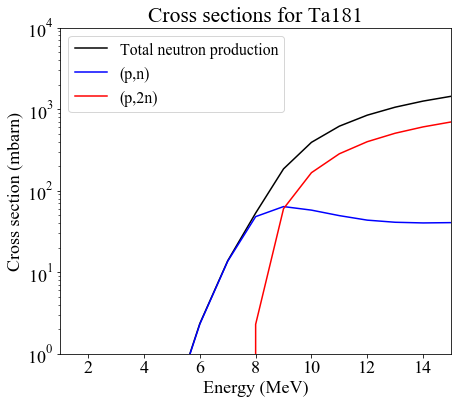

In [63]:
plt.plot(ta181_pnx_xsec[:,0],ta181_pnx_xsec[:,1],'-k',label='Total neutron production')
plt.plot(ta181_pn_xsec[:,0],ta181_pn_xsec[:,1],'-b',label='(p,n)')
plt.plot(ta181_p2n_xsec[:,0],ta181_p2n_xsec[:,1],'-r',label='(p,2n)')
#plt.plot(ta181_pn_xsec[:,0],ta181_pn_xsec[:,1]+ta181_p2n_xsec[:,1],'-m',label='(p,n)+(p,2n)')

plt.xlabel('Energy (MeV)')
plt.ylabel('Cross section (mbarn)')
#plt.xscale('log')
plt.yscale('log')
plt.xlim(1.,15.)
plt.ylim(1.,1.e4)
plt.title('Cross sections for Ta181')
plt.legend(fontsize=16)

Text(0, 0.5, 'Cross section (mbarn)')

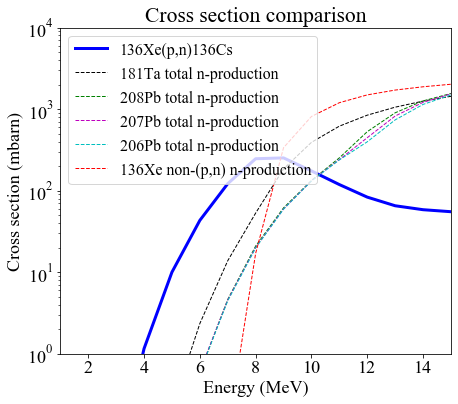

In [64]:
# Direct cross-section comparisons:
plt.plot(xe136_pn_xsec[:,0],xe136_pn_xsec[:,1],'-b',\
         label='136Xe(p,n)136Cs',linewidth=3)
plt.plot(ta181_pnx_xsec[:,0],ta181_pnx_xsec[:,1],'--k',\
         label='181Ta total n-production',linewidth=1)
plt.plot(pb208_pnx_xsec[:,0],pb208_pnx_xsec[:,1],'--g',\
        label='208Pb total n-production',linewidth=1)
plt.plot(pb207_pnx_xsec[:,0],pb207_pnx_xsec[:,1],'--m',\
        label='207Pb total n-production',linewidth=1)
plt.plot(pb206_pnx_xsec[:,0],pb206_pnx_xsec[:,1],'--c',\
        label='206Pb total n-production',linewidth=1)
plt.plot(xe136_pn_xsec[:,0],xe136_pnx_xsec[:,1]-xe136_pn_xsec[:,1],'--r',\
         label='136Xe non-(p,n) n-production',linewidth=1)
plt.yscale('log')
plt.xlim(1.,15.)
plt.ylim(1.,1.e4)
plt.title('Cross section comparison')
plt.legend(fontsize=16)
plt.xlabel('Energy (MeV)')
plt.ylabel('Cross section (mbarn)')

0.1mil Ta foil: 			2.813e+19 atoms per cm^2
0.5in Xe gas cell (at 295K, 1 bar): 	2.979e+19 atoms per cm^2


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide


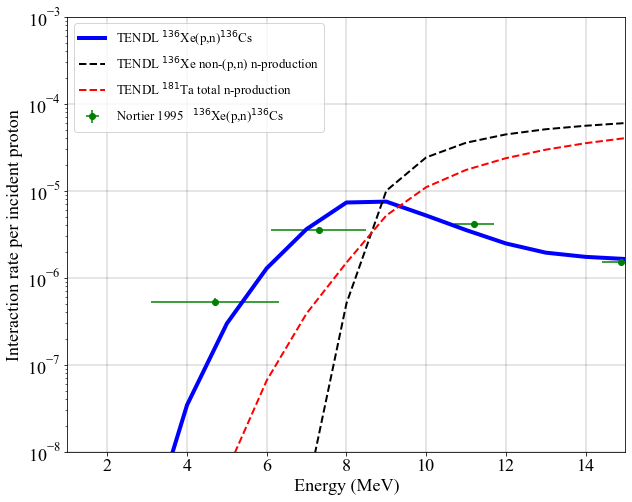

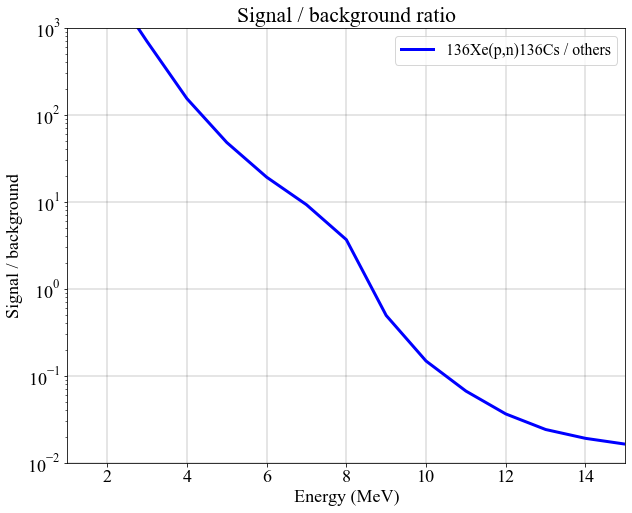

In [67]:
# Data from Nortier. Cross sections are for natXe, so need to be 
# scaled by abundance of 136Xe
nortier_E = np.array([4.7,7.3,11.2,14.9,18.6])
nortier_xsec = np.array([1.57,10.5,12.4,4.55,3.64])
nortier_yerror = np.array([0.16,0.86,1.0,0.4,0.33])
nortier_xerror = np.array([1.6,1.2,0.5,0.5,0.5])

xe136_ab = 0.08857


#To get the actual relative event rates, we also need target densities.
ta_density = 16.65 # g/cm3
xe_gas_density = 0.0053 # g/cm3

ta_thickness = 0.0001 * 2.54 # cm
target_diameter = 0.5 * 2.54 # cm

# Get the target density in nuclei per cm2
ta_target_density = ta_density * ta_thickness * 2 / 181 * 6.02e23  # Factor of two for entrance + exit
xe_target_density = xe_gas_density * target_diameter / 136 * 6.02e23


print('0.1mil Ta foil: \t\t\t{:4.4} atoms per cm^2'.format(ta_target_density))
print('0.5in Xe gas cell (at 295K, 1 bar): \t{:4.4} atoms per cm^2'.format(xe_target_density))


# Direct event rate comparisons:
plt.plot(xe136_pn_xsec[:,0],xe136_pn_xsec[:,1]*1e-27*xe_target_density,'-b',\
         label=r'TENDL $^{136}$Xe(p,n)$^{136}$Cs',linewidth=4)
plt.plot(xe136_pn_xsec[:,0],(xe136_pnx_xsec[:,1]-xe136_pn_xsec[:,1])*1e-27*xe_target_density,'--k',\
         label=r'TENDL $^{136}$Xe non-(p,n) n-production',linewidth=2)
plt.plot(ta181_pnx_xsec[:,0],ta181_pnx_xsec[:,1]*1e-27*ta_target_density,'--r',\
         label=r'TENDL $^{181}$Ta total n-production',linewidth=2)
# plt.plot(pb208_pnx_xsec[:,0],pb208_pnx_xsec[:,1]*1e-27,'--r',\
#         label='208Pb total n-production',linewidth=1)
plt.errorbar( nortier_E, nortier_xsec*1e-27*xe_target_density/xe136_ab,\
             yerr=nortier_yerror*1e-27*xe_target_density/xe136_ab, \
             xerr=nortier_xerror,\
             fmt='og', label=r'Nortier 1995   $^{136}$Xe(p,n)$^{136}$Cs')
plt.yscale('log')
plt.xlim(1.,15.)
plt.ylim(1.e-8,1.e-3)
#plt.title('Relative event rates')
plt.legend(fontsize=13,)
plt.xlabel('Energy (MeV)')
plt.ylabel('Interaction rate per incident proton')
plt.grid(linewidth=0.2,color=(0.,0.,0.,0.2))
plt.savefig('plots/event_rate_per_proton_0p1mil_Ta_foil_0p5in_Xe_cell.png',\
            dpi=200,\
            bbox_inches='tight')


# Ratio of signal / background
plt.figure(2)
plt.plot( xe136_pn_xsec[:,0], xe136_pn_xsec[:,1]*1e-27*xe_target_density / \
         (ta181_pnx_xsec[:,1]*1e-27*ta_target_density + (xe136_pnx_xsec[:,1]-xe136_pn_xsec[:,1])*1e-27*xe_target_density),\
         '-b',\
         label='136Xe(p,n)136Cs / others',linewidth=3)

plt.yscale('log')
plt.xlim(1.,15.)
plt.ylim(1.e-2,1.e3)
plt.title('Signal / background ratio')
plt.legend(fontsize=16)
plt.xlabel('Energy (MeV)')
plt.ylabel('Signal / background')
plt.grid(linewidth=0.2,color=(0.,0.,0.,0.2))
plt.savefig('plots/signal_background_ratio_0p1mil_Ta_foil_0p5in_Xe_cell.png',\
            dpi=200,\
            bbox_inches='tight')



In [59]:
from scipy.interpolate import interp1d

# assuming 0.5" gas cell
xe136_pn_func = interp1d(xe136_pn_xsec[:,0],xe136_pn_xsec[:,1]*1e-27*xe_target_density)



def InteractionsPerPulse( energy_MeV, period_us, current_nA ):
    
    current_in_protons = (current_nA * 1e-9) / 1.6e-19
    beam_pulse_rate = 1./(period_us * 1e-6)
    
    protons_per_pulse = current_in_protons / beam_pulse_rate
    
    return xe136_pn_func(energy_MeV) * protons_per_pulse

def InteractionsPerHour( energy_MeV, current_nA ):
    
    current_in_protons = (current_nA * 1e-9) / 1.6e-19
    
    interactions_per_s = xe136_pn_func(energy_MeV) * current_in_protons
    
    return interactions_per_s * 60 * 60
    
    

E = 5 MeV, rate = 0.07454 evts/pulse
E = 7 MeV, rate = 0.9072 evts/pulse
E = 8 MeV, rate = 1.834 evts/pulse
E = 10 MeV, rate =  1.3 evts/pulse


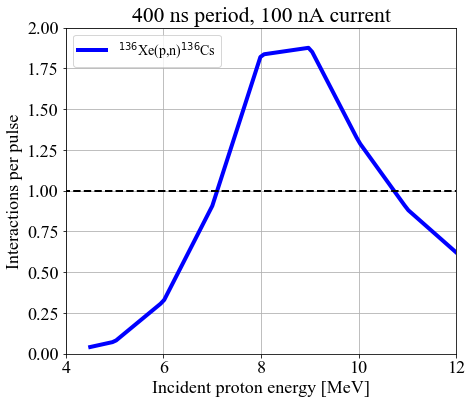

In [69]:
energy = np.linspace(4.5,12.,100)
interactions = InteractionsPerPulse(energy,0.4,100.)

for e in [5,7,8,10]:
    print('E = {} MeV, rate = {:4.4} evts/pulse'.format(e,InteractionsPerPulse(e,0.4,100.)))

plt.plot(energy,interactions,'-b',linewidth=4,\
         label=r'$^{136}$Xe(p,n)$^{136}$Cs')
plt.plot(np.linspace(0.,100.,100),np.ones(100),'--k',linewidth=2)
plt.xlim(4.,12.)
plt.ylim(0.,2.)

plt.xlabel('Incident proton energy [MeV]')
plt.ylabel('Interactions per pulse')
plt.title('400 ns period, 100 nA current')
plt.legend(fontsize=14)
plt.grid()
plt.savefig('plots/interactions_per_pulse_400ns_100nA.png',dpi=200,bbox_inches='tight')


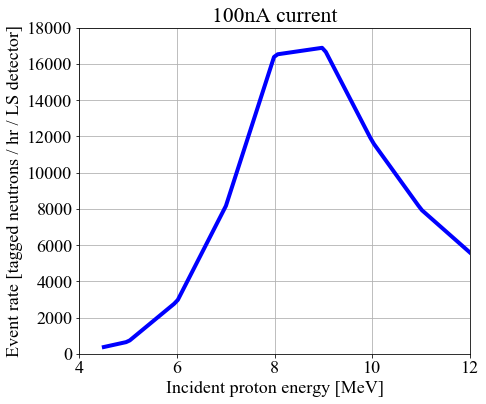

In [71]:
interactions_per_hour = InteractionsPerHour(energy,100.)

plt.plot(energy,interactions_per_hour * 1e-6,'-b',linewidth=4,\
        label=r'$^{136}$Xe(p,n)$^{136}$Cs')

plt.xlabel('Incident proton energy [MeV]')
plt.ylabel('Event rate [tagged neutrons / hr / LS detector]')
plt.title('100nA current')
plt.grid()
plt.xlim(4.,12.)
plt.ylim(0.,18000.)

plt.savefig('plots/event_rate_per_hour_100nA.png',dpi=200,bbox_inches='tight')